In [ ]:
# according to: https://stable-baselines3.readthedocs.io/en/master/common/monitor.html#stable_baselines3.common.monitor.ResultsWriter.write_row,
# these are the episode returns (sum of all rewards received over the course of the episode) and NOT the average reward

%load_ext autoreload
%autoreload 2

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy, window_func
from stable_baselines3.common.monitor import load_results

from zfa.core.default_dirs import MODEL_CKPT_DIR
import socket

if socket.gethostname().startswith("dhcp"):
    MODEL_CKPT_DIR = os.path.expanduser("~/Desktop/")
    
LOG_DIR = os.path.join(MODEL_CKPT_DIR, "swimmer3_unityenv_novision_mlp300200_mlp400300_ppo_seed1_numparallel25/")

In [ ]:
LOG_DIR

# 1. Plot results

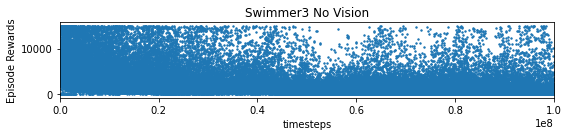

In [30]:
results_plotter.plot_results([LOG_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Swimmer3 No Vision")

In [9]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

from typing import Callable, List, Optional, Tuple
EPISODES_WINDOW = 100
def plot_curves(
    xy_list: List[Tuple[np.ndarray, np.ndarray]], x_axis: str, title: str, figsize: Tuple[int, int] = (8, 2)
) -> None:
    """
    plot the curves

    :param xy_list: the x and y coordinates to plot
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: the title of the plot
    :param figsize: Size of the figure (width, height)
    """

    plt.figure(title, figsize=figsize)
    max_x = max(xy[0][-1] for xy in xy_list)
    min_x = 0
    for _, (x, y) in enumerate(xy_list):
        plt.scatter(x, y, s=2)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color="r")
    plt.xlim(min_x, max_x)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Episode Rewards")
    plt.tight_layout()


def plot_results_scatter(
    dirs: List[str], num_timesteps: Optional[int], x_axis: str, task_name: str, figsize: Tuple[int, int] = (8, 2)
) -> None:
    """
    Plot the results using csv files from ``Monitor`` wrapper.

    :param dirs: the save location of the results to plot
    :param num_timesteps: only plot the points below this value
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: the title of the task to plot
    :param figsize: Size of the figure (width, height)
    """

    data_frames = []
    for folder in dirs:
        data_frame = load_results(folder)
        if num_timesteps is not None:
            data_frame = data_frame[data_frame.l.cumsum() <= num_timesteps]
        data_frames.append(data_frame)
    xy_list = [ts2xy(data_frame, x_axis) for data_frame in data_frames]
    plot_curves(xy_list, x_axis, task_name, figsize)
    

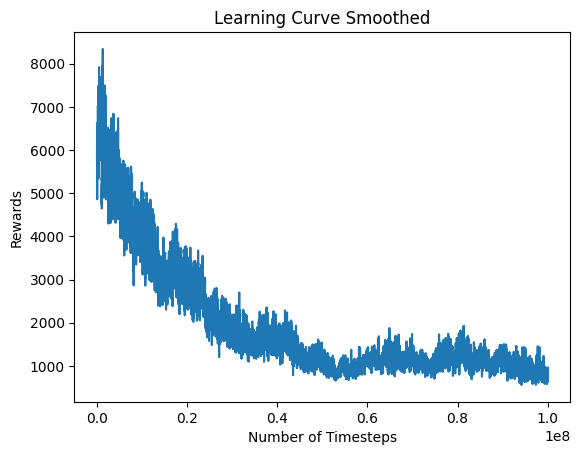

In [10]:
plot_results(LOG_DIR)

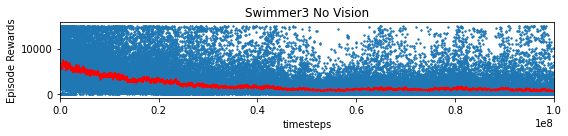

In [60]:
plot_results_scatter([LOG_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Swimmer3 No Vision")

In [11]:
results = load_results(LOG_DIR)

In [25]:
results

,index,r,l,t
0,0,1.00000,1,2.170863
1,1,1.00000,1,2.170975
2,2,1.00000,1,2.170991
3,3,3305.14670,1000,31.865083
4,4,12558.91200,1000,31.865152
...,...,...,...,...
100268,100268,887.16425,1000,169439.578520
100269,100269,670.51380,1000,169439.945135
100270,100270,965.59247,1000,169439.993126
100271,100271,272.64474,1000,169440.481139


In [16]:
x, r = ts2xy(results, results_plotter.X_TIMESTEPS)

In [17]:
x.shape[0]

100273

In [18]:
r.shape[0]

100273

In [13]:
x_eps, r_eps = ts2xy(results, results_plotter.X_EPISODES)

In [39]:
x_eps

array([     0,      1,      2, ..., 100270, 100271, 100272])

In [40]:
x

array([        1,         2,         3, ..., 100029854, 100030854,
       100031854])

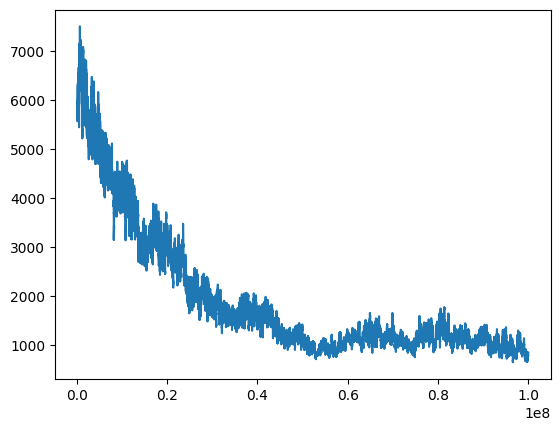

In [21]:
x, r_mean = window_func(x, r, 100, np.mean)
plt.plot(x, r_mean)

In [22]:
r_mean.shape

(100174,)

In [23]:
x.shape

(100174,)

In [24]:
x[np.argmax(r_mean)]

643302

In [25]:
import os
import re

def closest_step_file(desired_step, directory=LOG_DIR):
    closest_step = None
    closest_file = None
    
    # regular expression to match the filenames
    pattern = re.compile(r'(.*)_(\d+)_steps\.zip')
    
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            # extract the STEPNUMBER from the filename
            step = int(match.group(2))
            if closest_step is None or abs(desired_step - step) < abs(desired_step - closest_step):
                closest_step = step
                closest_file = filename

    return closest_file

# usage
print(closest_step_file(x[np.argmax(r_mean)]))


swimmer3_unityenv_novision_mlp300200_mlp400300_ppo_seed1_numparallel25_500000_steps.zip


# 2. Visually Evaluate Policy from Camera

In [2]:
import torch
import torch.nn as nn

os.environ["MUJOCO_GL"] = "egl"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

from zfa.model_training.train_sb3unity_ppo import make_env, SWIMMER3_UNITY_ENV_PATH_LINUX
from zfa.core.default_dirs import UNITY_BUILDS_DIR


# SWIMMER3_UNITY_GRAPHICS = os.path.join(UNITY_BUILDS_DIR, "swimmer3_linux_graphics/swimmer3.x86_64")
# SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/swimmer3_zebrafish_build_macosx.app")
SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_swimmer3_zebrafish_build_macosx.app")

def make_env_nosubproc(env_path, rank=0, seed=1):
    from mlagents_envs.environment import UnityEnvironment
    from zfa.model_training.utils import UnityToGymWrapperIgnorePixels
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    #from stable_baselines3.common.vec_env import VecEnv
    
    env = UnityEnvironment(env_path, worker_id=rank, seed=seed + rank)
    env = UnityToGymWrapperIgnorePixels(env, allow_multiple_obs=True)
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

# eval_env = SubprocVecEnv(
#     [
#         make_env(
#             env_path=SWIMMER3_UNITY_ENV_PATH_LINUX,
#             rank=rank,
#             seed=100,
#         )
#         for rank in range(1)
#     ]
# )
# # wrap it to log metrics
# eval_env = VecMonitor(eval_env)

eval_env = make_env_nosubproc(
#         env_path=SWIMMER3_UNITY_ENV_PATH_LINUX,
        env_path=SWIMMER3_UNITY_GRAPHICS,
        rank=0,
        seed=100,
    )

policy_kwargs = dict(
    activation_fn=nn.ReLU, net_arch=dict(pi=[300, 200], vf=[400, 300])
)

# Pass the net_arch parameter to the model
# Note: PPO takes an n_steps argument that you can manually set to n_steps=2048 // args.num_parallel, if you want to run 2048 steps total across environments, rather than 2048 per environment.
model = PPO(
    "MlpPolicy",
    eval_env,
    verbose=1,
    device=device,
    policy_kwargs=policy_kwargs,
)

model=PPO.load(os.path.join(LOG_DIR, "final_model.zip"))
# model=PPO.load(os.path.join(LOG_DIR, "swimmer3_unityenv_novision_mlp300200_mlp400300_ppo_seed1_numparallel25_500000_steps.zip"))

Using CPU
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-all

/Users/anayebi/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
returns, ep_lens = evaluate_policy(model, eval_env, 
                                   deterministic=True, render=True, 
                                   return_episode_rewards=True, n_eval_episodes=5)

/Users/anayebi/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:234: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


In [4]:
print(returns)
print(ep_lens)

[8147.607175, 12392.717787, 4676.44146, 14889.670197, 8938.819457]
[1000, 1000, 1000, 1000, 1000]


In [5]:
im = eval_env.render()

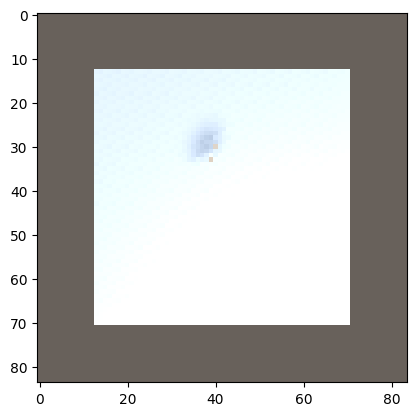

In [6]:
plt.imshow(im)

# 3. Exporting to ONNX to run in Unity in real time

In [ ]:
import torch
import torch.nn as nn
from stable_baselines3 import PPO
import os

LOG_DIR = os.path.expanduser("~/Desktop/")
SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/swimmer3_zebrafish_build_macosx.app")

os.environ["MUJOCO_GL"] = "egl"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    

def make_env_nosubproc(env_path, rank=0, seed=1):
    from mlagents_envs.environment import UnityEnvironment
    from zfa.model_training.utils import UnityToGymWrapperIgnorePixels
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    #from stable_baselines3.common.vec_env import VecEnv
    
    env = UnityEnvironment(env_path, worker_id=rank, seed=seed + rank)
    env = UnityToGymWrapperIgnorePixels(env, allow_multiple_obs=True)
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

class OnnxablePolicy(torch.nn.Module):
    def __init__(self, extractor, action_net, value_net):
        super().__init__()
        self.extractor = extractor
        self.action_net = action_net
        self.value_net = value_net

    def forward(self, observation):
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        action_hidden, value_hidden = self.extractor(observation)
#         return self.action_net(action_hidden), self.value_net(value_hidden)
        return self.action_net(action_hidden)


eval_env = make_env_nosubproc(
        env_path=SWIMMER3_UNITY_GRAPHICS,
        rank=0,
        seed=100,
    )

policy_kwargs = dict(
    activation_fn=nn.ReLU, net_arch=dict(pi=[300, 200], vf=[400, 300])
)

# Pass the net_arch parameter to the model
model = PPO(
    "MlpPolicy",
    eval_env,
    verbose=1,
    device=device,
    policy_kwargs=policy_kwargs,
)

model = PPO.load(os.path.join(LOG_DIR, "final_model"))
onnxable_model = OnnxablePolicy(
    model.policy.mlp_extractor, model.policy.action_net, model.policy.value_net
)

observation_size = model.observation_space.shape
dummy_input = torch.randn(1, *observation_size)
torch.onnx.export(
    onnxable_model,
    dummy_input,
    os.path.join(LOG_DIR, "swimmer3_ppo_model_actor.onnx"),
    opset_version=9,
    input_names=["input"],
)

In [3]:
observation_size

(27,)

In [4]:
onnxable_model.action_net

Linear(in_features=200, out_features=2, bias=True)

In [5]:
import onnx

# Load the ONNX model
model = onnx.load(os.path.join(LOG_DIR, "swimmer3_ppo_model_actor.onnx"))

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

# Set the version number
model.producer_version = "1.6.0"  # Set the version number here

# Save the model
onnx.save(model, "updated_swimmer3_ppo_model_actor.onnx")

graph torch-jit-export (
  %input[FLOAT, 1x27]
) initializers (
  %extractor.policy_net.0.weight[FLOAT, 300x27]
  %extractor.policy_net.0.bias[FLOAT, 300]
  %extractor.policy_net.2.weight[FLOAT, 200x300]
  %extractor.policy_net.2.bias[FLOAT, 200]
  %action_net.weight[FLOAT, 2x200]
  %action_net.bias[FLOAT, 2]
) {
  %input.1 = Gemm[alpha = 1, beta = 1, transB = 1](%input, %extractor.policy_net.0.weight, %extractor.policy_net.0.bias)
  %onnx::Gemm_14 = Relu(%input.1)
  %input.3 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_14, %extractor.policy_net.2.weight, %extractor.policy_net.2.bias)
  %onnx::Gemm_16 = Relu(%input.3)
  %17 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_16, %action_net.weight, %action_net.bias)
  return %17
}


In [6]:
import onnx
from onnx import helper

# Load the model
model = onnx.load(os.path.join(LOG_DIR, "swimmer3_ppo_model_actor.onnx"))

# Create a tensor for the version number
version_number_tensor = helper.make_tensor(
    'VersionNumber',                    # tensor name (string)
    onnx.TensorProto.FLOAT,             # tensor data type
    dims=(1,),                          # tensor shape as tuple
    vals=[2.0],                         # tensor values
)

# Add the version number tensor to the graph
model.graph.initializer.append(version_number_tensor)

# Save the model
onnx.save(model, "updated_swimmer3_ppo_model_actor.onnx")

In [7]:
import onnx

# Load the model
model = onnx.load(os.path.join(LOG_DIR, "swimmer3_ppo_model_actor.onnx"))

# Write into the ProducerName field
model.producer_name = "torch-jit-export 2"

# Save the model
onnx.save(model, "updated_model.onnx")

In [8]:
torch.__version__

'1.11.0'